In [ ]:
'''
The script reads sst raw data from CESM-LENS and output:
1) pre-process and concatenate 40 ensembles of z500
2) conduct EOF analysis of sst

'''

In [ ]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import pandas as pd
from eofs.xarray import Eof

import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

import pickle
import joblib

In [2]:
# return monthly average and regional longitude, latitude
# extract and group each month data
# after calculate the anomaly, remove the outliers
def month_data_z(anom, month):
    month_group = anom.groupby("time.month").groups # group into seasons, use groups to read each group
    month_index = month_group[month]
    month_anom = anom[month_index,:,:]

    return month_anom


# calculate normalized anomalies -- CESM
# climatology based on 1976 to 2005 
def nor_anom(dataset):
    ds_clm = dataset.sel(time=slice("1976", "2005")).load()
    rr_clm = ds_clm

    gb_clm = rr_clm.groupby("time.month") # gb_clm: grouped data into 12 month for climatology
    gb = dataset.groupby("time.month")
    prcp_anom = ((gb - gb_clm.mean(dim="time")).groupby("time.month"))/gb_clm.std(dim="time") # normalized
    return prcp_anom

In [3]:
def data_load_cesm_z(fn, start, end, region): # 'NP' 'NA' 
    ds_xr = xr.open_dataset(fn, chunks={"time": 10})
    ds_xr = ds_xr.sel(time=slice(start, end)).load()
    reg_lon_xr = ds_xr['lon'] # from -40.375W to 75.375E
    reg_lat_xr = ds_xr['lat'] # from 25.375N to 75.375N
    temp_xr = ds_xr['Z500']
    ## daily to monthly
    monthly_z = temp_xr.resample(time = '1M').mean()
    # lat: -20 to 90; lon: -90W to 90E
    if region == 'NP': 
        # combine for merge two dataset with same coordinate
        xr1 = monthly_z[:,127:171,92:193] # (29N:70N; 115E:120W)
    if region == 'NA': 
        # combine for merge two dataset with same coordinate
        xr1 = xr.concat([monthly_z[:,75:,216:],monthly_z[:,75:,:73]], dim="lon")
    
    return xr1, reg_lat_xr, reg_lon_xr

In [9]:
import os
path = '/Data/gfi/share/ModData/CESM_LENS/Z500'
filelist = os.listdir(path)

pathlist = []
for i in range(len(filelist)):
    temp = path + '/' + filelist[i]
    pathlist.append(temp)
    
fn1 = pathlist[0]
# take the right time
temp_xr = xr.open_dataset(fn1, chunks={"time": 19968})
### only ensemble 1 have 192001 ###
temp_xr = temp_xr.sel(time=slice('192001', '200512')).load() # be aware of the time here!!!

In [10]:
# preprocess SST -- all data together
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

## change parameter for different region ##
region = 'NA'

fn1 = pathlist[0]

z_xr, reg_lat_xr, reg_lon_xr = data_load_cesm_z(fn1, '192001', '200512', region) # only monthly data has that problem

# calculate anomaly
z_anom = nor_anom(z_xr)

# detrend the time series at each grid point
z_danom = detrend_dim(z_anom, 'time', deg=1)

# extract and group each season data
anom_original = z_danom

data = anom_original.values # remove dimension = 1
time = anom_original.time
lat = anom_original.lat
lon = anom_original.lon
anom_ensemble = xr.DataArray(data, 
                        coords=[time, lat,lon], 
                        dims=['time', 'lat', 'lon'])

In [11]:
##### ensemble #####
for i in range(1,len(filelist)):

    fn1 = pathlist[i]
    z_xr, reg_lat_xr, reg_lon_xr = data_load_cesm_z(fn1, '192001', '200512', region)


    # calculate anomaly
    z_anom = nor_anom(z_xr)

    # detrend the time series at each grid point
    z_danom = detrend_dim(z_anom, 'time', deg=1)
    
    anom_gb_temp = z_danom
    
    data = z_danom.values # remove dimension = 1
    time = anom_original.time
    lat = anom_original.lat
    lon = anom_original.lon
    anom_gb_temp = xr.DataArray(data, 
                            coords=[time, lat,lon], 
                            dims=['time', 'lat', 'lon'])

    anom_ensemble = xr.concat([anom_ensemble,anom_gb_temp], dim='time')

In [5]:
### save and load as netcdf ###
anom_ensemble.to_netcdf(r'/shared/home/yzh086/code/task1/result/ensemble/z500_na.nc')

NameError: name 'anom_ensemble' is not defined

In [14]:
ensemble = anom_ensemble

In [55]:
### save and load as netcdf ###
ensemble = xr.open_dataset(r'/shared/home/yzh086/code/task1/result/ensemble/z500_np.nc')

In [56]:
ensemble = ensemble.__xarray_dataarray_variable__

In [9]:
##### preprocessing wrong data ####
ensemble[33243] = ensemble[33231]

TypeError: this variable's data is stored in a dask array, which does not support item assignment. To assign to this variable, you must first load it into memory explicitly using the .load() method or accessing its .values attribute.

In [57]:
region = 'np'

In [58]:
### For winter ###
sst_raw = ensemble
# find SEASONAL data
sst_all = sst_raw[sst_raw.time.dt.month.isin([12,1,2])] # select data of 12,1,2 month
# take the rolling series from 1921 to 2005
sst_rolling = sst_all[2:-1]
sst_mean1 = sst_rolling.rolling(time = 3).mean()
# mean value at each step 3
sst2 = sst_mean1[sst_mean1.time.dt.month == 2]
# mean at 1920
sst1 = sst_all[:2].mean(dim='time')
# reshape time to (1,)
time = sst_all[1].time.values.reshape(1,)
lat = sst_all[1].lat
lon = sst_all[1].lon
sst1 = xr.DataArray(sst1.values.reshape(1,sst_all.shape[1],sst_all.shape[2]),coords=[time,lat,lon],dims=('time', 'lat', 'lon'))

# concat two array
sst_series = xr.concat([sst1, sst2], dim="time")

In [60]:
### EOF ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# weighted by latitude
meantlat = sst_series.lat
wgts   = np.cos(np.deg2rad(meantlat))
#wgts   = np.array(wgts).reshape(len(wgts), 1)
wgts   = np.array(wgts).reshape(44, 1) ## depends on the shape of region

solver = Eof(sst_series, weights=wgts)

eof_en = solver.eofs(neofs=10)
pc_en  = solver.pcs(npcs=10, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

eof_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_z500/z500_eof_djf_%s.nc' % region)
pc_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_z500/z500_pc_djf_%s.nc' % region)
varfrac_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_z500/z500_var_djf_%s.nc' % region)
lambdas_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_z500/z500_lam_djf_%s.nc' % region)

In [61]:
### For MAM ###
sst_raw = ensemble
# find SEASONAL data
sst_all = sst_raw[sst_raw.time.dt.month.isin([3,4,5])] # select data of each season
# take the rolling series from 1921 to 2005
sst_rolling = sst_all
sst_mean1 = sst_rolling.rolling(time = 3).mean()
# mean value at each step 3
sst2 = sst_mean1[sst_mean1.time.dt.month == 5]

# concat two array
sst_series = sst2

### EOF ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# weighted by latitude
meantlat = meantlat = sst_series.lat
wgts   = np.cos(np.deg2rad(meantlat))
#wgts   = np.array(wgts).reshape(len(wgts), 1)
wgts   = np.array(wgts).reshape(44, 1) ## depends on the shape of region

solver = Eof(sst_series, weights=wgts)

eof_en = solver.eofs(neofs=10)
pc_en  = solver.pcs(npcs=10, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

eof_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_z500/z500_eof_mam_%s.nc' % region)
pc_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_z500/z500_pc_mam_%s.nc' % region)
varfrac_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_z500/z500_var_mam_%s.nc' % region)
lambdas_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_z500/z500_lam_mam_%s.nc' % region)

In [62]:
### For JJA ###
sst_raw = ensemble
# find SEASONAL data
sst_all = sst_raw[sst_raw.time.dt.month.isin([6,7,8])] # select data of each season
# take the rolling series from 1921 to 2005
sst_rolling = sst_all
sst_mean1 = sst_rolling.rolling(time = 3).mean()
# mean value at each step 3
sst2 = sst_mean1[sst_mean1.time.dt.month == 8]

# concat two array
sst_series = sst2

### EOF ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# weighted by latitude
meantlat = meantlat = sst_series.lat
wgts   = np.cos(np.deg2rad(meantlat))
#wgts   = np.array(wgts).reshape(len(wgts), 1)
wgts   = np.array(wgts).reshape(44, 1) ## depends on the shape of region

solver = Eof(sst_series, weights=wgts)

eof_en = solver.eofs(neofs=10)
pc_en  = solver.pcs(npcs=10, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

eof_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_z500/z500_eof_jja_%s.nc' % region)
pc_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_z500/z500_pc_jja_%s.nc' % region)
varfrac_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_z500/z500_var_jja_%s.nc' % region)
lambdas_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_z500/z500_lam_jja_%s.nc' % region)

In [63]:
### For SON ###
sst_raw = ensemble
# find SEASONAL data
sst_all = sst_raw[sst_raw.time.dt.month.isin([9,10,11])] # select data of each season
# take the rolling series from 1921 to 2005
sst_rolling = sst_all
sst_mean1 = sst_rolling.rolling(time = 3).mean()
# mean value at each step 3
sst2 = sst_mean1[sst_mean1.time.dt.month == 11]
# concat two array
sst_series = sst2

### EOF ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# weighted by latitude
meantlat = meantlat = sst_series.lat
wgts   = np.cos(np.deg2rad(meantlat))
#wgts   = np.array(wgts).reshape(len(wgts), 1)
wgts   = np.array(wgts).reshape(44, 1) ## depends on the shape of region

solver = Eof(sst_series, weights=wgts)

eof_en = solver.eofs(neofs=10)
pc_en  = solver.pcs(npcs=10, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

eof_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_z500/z500_eof_son_%s.nc' % region)
pc_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_z500/z500_pc_son_%s.nc' % region)
varfrac_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_z500/z500_var_son_%s.nc' % region)
lambdas_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_z500/z500_lam_son_%s.nc' % region)

In [ ]:
### For MAM ###
sst_raw = ensemble
# find SEASONAL data
sst_all = sst_raw[sst_raw.time.dt.month.isin([3,4,5])] # select data of each season
# take the rolling series from 1921 to 2005
sst_rolling = sst_all
sst_mean1 = sst_rolling.rolling(time = 3).mean()
# mean value at each step 3
sst2 = sst_mean1[sst_mean1.time.dt.month == 5]
# concat two array
sst_series = sst2

In [ ]:
### EOF ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# weighted by latitude
meantlat = meantlat = sst_series.lat
wgts   = np.cos(np.deg2rad(meantlat))
#wgts   = np.array(wgts).reshape(len(wgts), 1)
wgts   = np.array(wgts).reshape(117, 1) ## depends on the shape of region

solver = Eof(sst_series, weights=wgts)

eof_en = solver.eofs(neofs=10)
pc_en  = solver.pcs(npcs=10, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

eof_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_eof_mam.nc')
pc_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_pc_mam.nc')
varfrac_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_var_mam.nc')
lambdas_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_lam_mam.nc')

In [18]:
### EOF ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# weighted by latitude
wgts   = np.cos(np.deg2rad(ensemble.lat))
wgts   = np.array(wgts).reshape(117, 1) ## depends on the shape of region

solver = Eof(ensemble, weights=wgts)

In [19]:
eof_en = solver.eofs(neofs=10)
pc_en  = solver.pcs(npcs=10, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

In [20]:
eof_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_z500/z500_eof_%s.nc' % region)
pc_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_z500/z500_pc4_%s.nc' % region)
varfrac_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_z500/z500_var_%s.nc' % region)
lambdas_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_z500/z500_lam_%s.nc' % region)

In [ ]:
##### save data #####
import joblib
joblib.dump(eof_en, r'/shared/home/yzh086/code/task1/result/eof_z500/z_%s_eof.pkl' % region
            ,compress=9)
joblib.dump(pc_en, r'/shared/home/yzh086/code/task1/result/eof_z500/z_%s_pc.pkl'% region
            ,compress=9)
joblib.dump(varfrac_en, r'/shared/home/yzh086/code/task1/result/eof_z500/z_%s_varfrac.pkl'% region
            ,compress=9)
joblib.dump(lambdas_en, r'/shared/home/yzh086/code/task1/result/eof_z500/z_%s_lambdas.pkl' % region
            ,compress=9)

In [ ]:
#### save as netcdf ###

In [9]:
##### open data #####
import joblib

eof_en = joblib.load(r'/shared/home/yzh086/code/task1/result/eof_z500/z_eof1.pkl' )
pc_en = joblib.load(r'/shared/home/yzh086/code/task1/result/eof_z500/z_pc1.pkl')
varfrac_en = joblib.load(r'/shared/home/yzh086/code/task1/result/eof_z500/z_varfrac1.pkl')
lambdas_en = joblib.load(r'/shared/home/yzh086/code/task1/result/eof_z500/z_lambdas1.pkl')

In [50]:
eof_en

<xarray.DataArray 'eofs' (mode: 10, lat: 33, lon: 129)>
array([[[-1.46287117e-02, -1.51238125e-02, -1.55905107e-02, ...,
         -1.74260440e-02, -1.73876164e-02, -1.73270851e-02],
        [-1.56349866e-02, -1.61341860e-02, -1.66232300e-02, ...,
         -1.66529235e-02, -1.66589743e-02, -1.66138558e-02],
        [-1.64915778e-02, -1.69960544e-02, -1.75061968e-02, ...,
         -1.57726527e-02, -1.58691335e-02, -1.58478109e-02],
        ...,
        [ 3.52953721e-03,  3.54137375e-03,  3.53365695e-03, ...,
          2.94601133e-03,  2.67170242e-03,  2.42357780e-03],
        [ 4.01977098e-03,  4.03229117e-03,  4.05257349e-03, ...,
          2.97872822e-03,  2.72619422e-03,  2.50067492e-03],
        [ 4.40185628e-03,  4.43568043e-03,  4.46078575e-03, ...,
          2.99973234e-03,  2.77174662e-03,  2.56719008e-03]],

       [[ 1.77458428e-02,  1.80644703e-02,  1.83608854e-02, ...,
          1.52826245e-03,  8.28808703e-04, -1.07806294e-04],
        [ 1.69510481e-02,  1.72516473e-02,  1.75423865e-02, ...,
          3.61360702e-03,  2.70501659e-03,  1.91458291e-03],
        [ 1.59803102e-02,  1.62844030e-02,  1.65550568e-02, ...,
          5.63267727e-03,  4.69820689e-03,  3.91741244e-03],
...
        [-1.65905031e-02, -1.66923550e-02, -1.67424010e-02, ...,
         -6.35092126e-03, -6.25405872e-03, -6.16640869e-03],
        [-1.44650660e-02, -1.45765485e-02, -1.45923114e-02, ...,
         -6.90317640e-03, -6.78899252e-03, -6.68680352e-03],
        [-1.23481527e-02, -1.24213740e-02, -1.24491997e-02, ...,
         -7.27836781e-03, -7.15122720e-03, -7.03247383e-03]],

       [[ 4.67184888e-02,  4.80124892e-02,  4.90119680e-02, ...,
         -2.73941720e-02, -2.62110787e-02, -2.49076050e-02],
        [ 4.64759279e-02,  4.76479380e-02,  4.85313344e-02, ...,
         -2.68557406e-02, -2.55547954e-02, -2.42442492e-02],
        [ 4.54915299e-02,  4.65985037e-02,  4.73913804e-02, ...,
         -2.57010269e-02, -2.45688153e-02, -2.31215530e-02],
        ...,
        [-1.46583851e-02, -1.47331695e-02, -1.47669818e-02, ...,
          1.73941260e-02,  1.72566104e-02,  1.70547562e-02],
        [-1.31009594e-02, -1.31670895e-02, -1.31620479e-02, ...,
          1.57915141e-02,  1.56488676e-02,  1.54382717e-02],
        [-1.15018714e-02, -1.15337066e-02, -1.15268090e-02, ...,
          1.41477310e-02,  1.40116304e-02,  1.38046821e-02]]])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9
  * lat      (lat) float64 35.34 36.28 37.23 38.17 ... 62.67 63.61 64.55 65.5
  * lon      (lon) float64 117.5 118.8 120.0 121.2 ... 273.8 275.0 276.2 277.5
Attributes:
    long_name:  empirical_orthogonal_functions

In [51]:
### re-apply for new coordinate since it is not equally placed ###
### this should be changed by different region ###
new_lat = np.linspace(35,65,33) # -20 to 20
new_long = np.linspace(118,277,129) # 110 E to 75 W

/Data/gfi/users/local/share/virtualenv/dynpie3-2021a/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


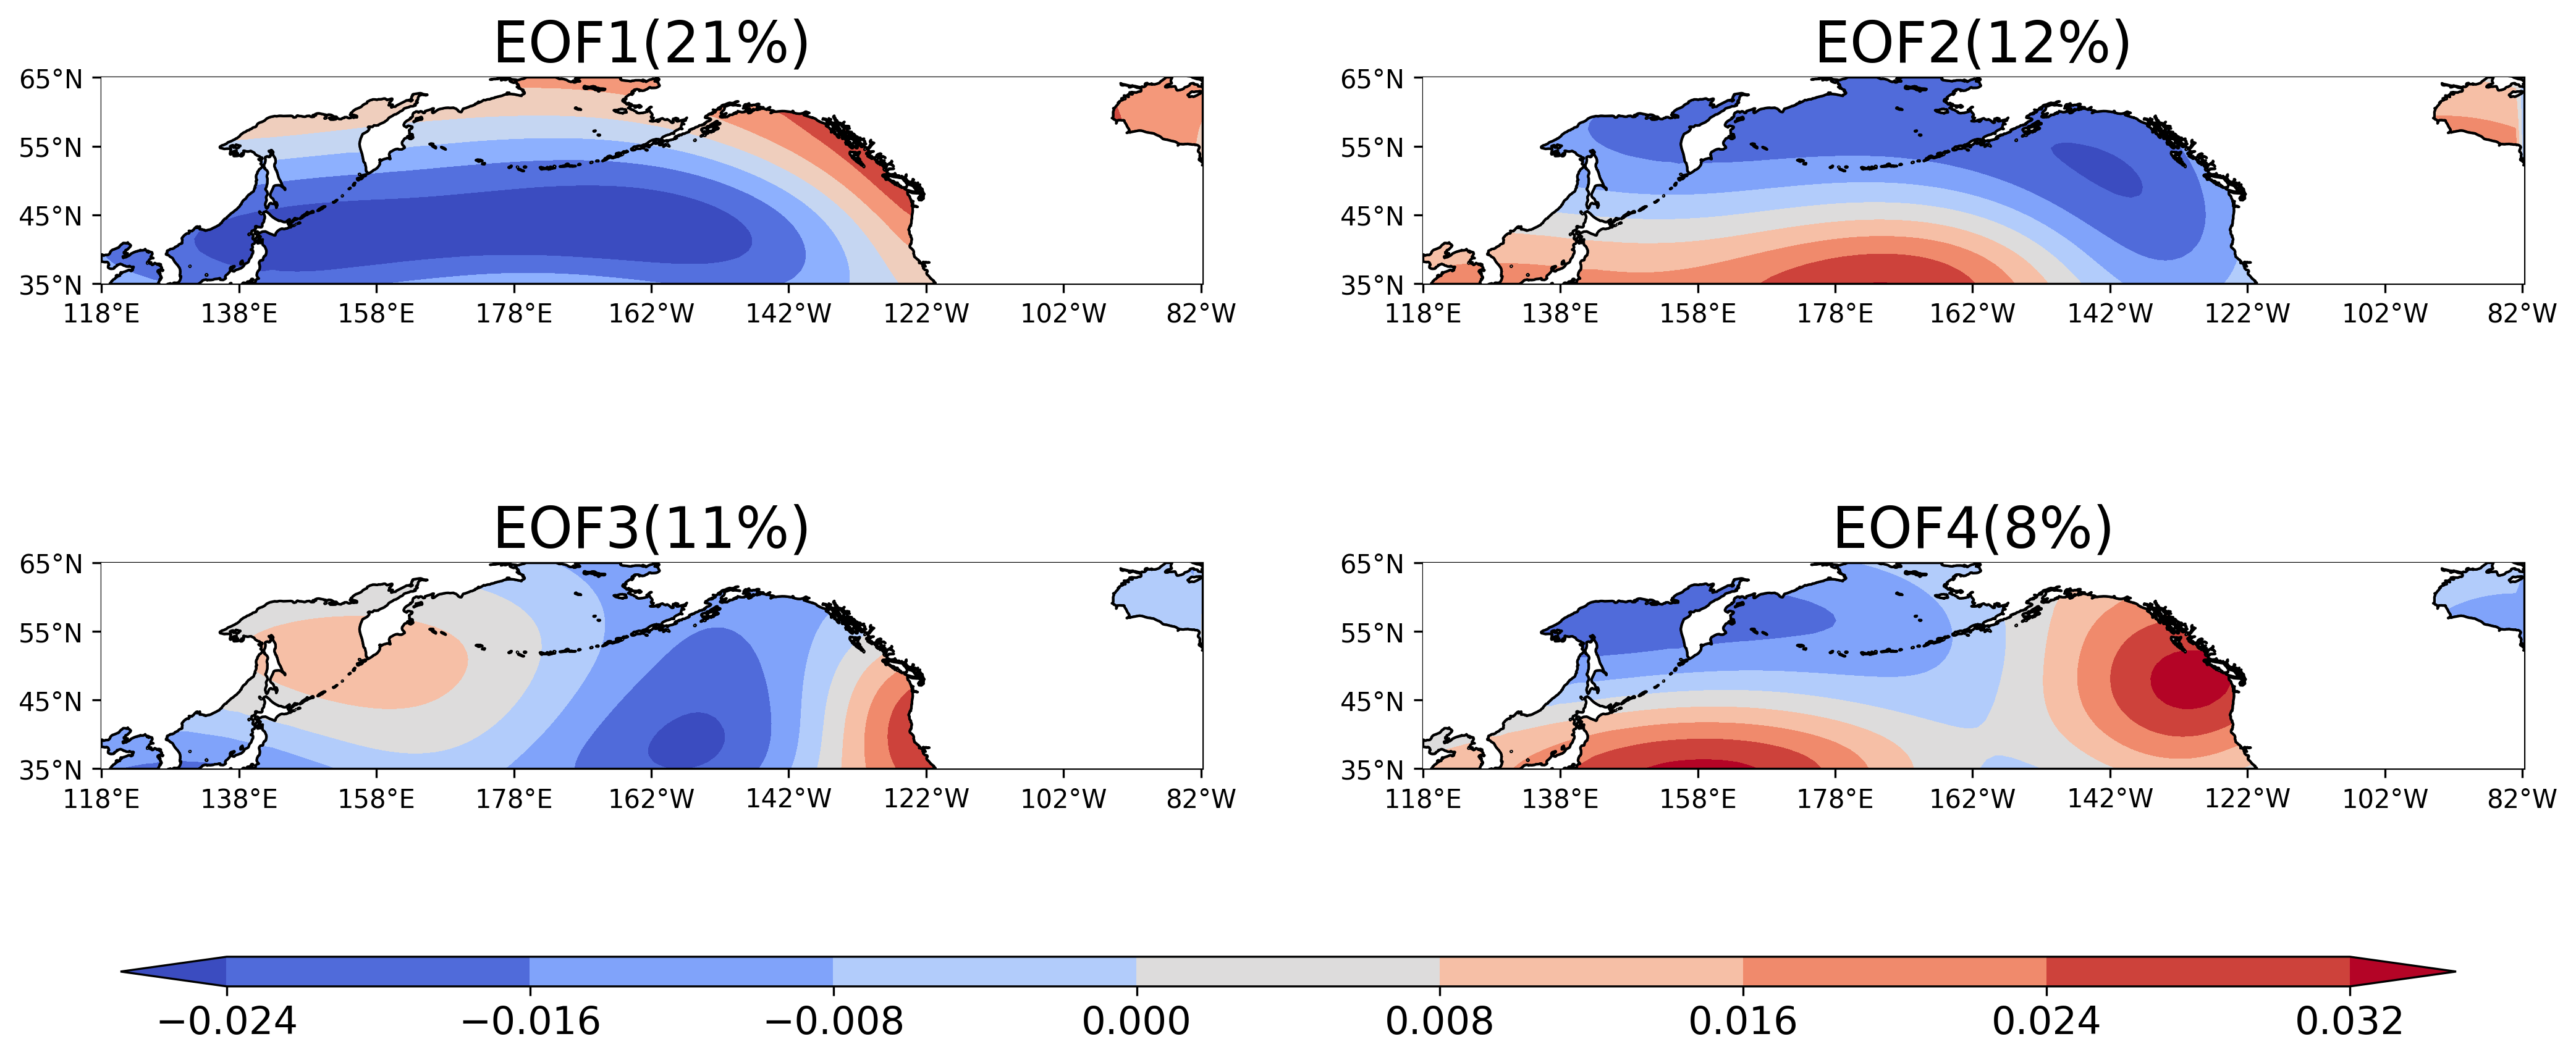

In [52]:
##### finally plot #####

fig, axs = plt.subplots(2,2, figsize=(14,8), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)),dpi =300)

fig = plt.gcf()

for ax, i in zip(axs.ravel(), range(4)):

    title2 = 'EOF%s(%s%%)' % (i+1, int(varfrac_en[i]*100))
    # tim
    data = eof_en[i]
    # Add cyclic point to data
    data, lons = add_cyclic_point(data, coord=new_long)
    lat = new_lat
    # Make a filled contour plot
    # Add coastlines
    ax.coastlines()

    # mask the LAND part with white color
    ax.add_feature(cart.feature.LAND, facecolor = 'white', zorder=200, edgecolor='k')

    cs=ax.contourf(lons, new_lat, data,
                transform = ccrs.PlateCarree(),cmap='coolwarm',#levels = np.linspace(-0.01,0.01,7),
                   extend='both') # (lat, lon)

    # Define the xticks for longitude

    ax.set_xticks(np.arange(118,280,20), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    ax.set_title(title2, fontsize = 22)

    ax.set_yticks(np.arange(35,70,10), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

fig.tight_layout()
fig.subplots_adjust(bottom = 0.1, top = 0.7, hspace =0.2, wspace=.2)    

# Add colorbar
bar_cax = plt.axes([0.05, 0.02, 0.9,0.02]) # left&right, bottom, size, size
cbar = plt.colorbar(cs,cax = bar_cax, orientation = 'horizontal', fraction = 0.05)
cbar.ax.tick_params(labelsize = 15)